In [1]:
# 1. 导入依赖

import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
#2.参数设置
BASE_PATH = '/kaggle/input/deepfake-and-real-images/Dataset'
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
VAL_PATH = os.path.join(BASE_PATH, 'Validation')
IMG_SIZE = 256
LEARNING_RATE = 1e-3  # 从头训练使用更高的学习率
EPOCHS = 10  # 从头训练需要更多轮数
WEIGHT_DECAY = 1e-4  # 添加权重衰减防止过拟合
MAX_VAL_SAMPLES = 6400  # 限制验证集样本数

# 多GPU设置
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_GPUS = torch.cuda.device_count()
print(f"🚀 深度学习模式 - 从头训练")
print(f"可用GPU数量: {NUM_GPUS}")
if NUM_GPUS > 1:
    print(f"使用多GPU训练: {[torch.cuda.get_device_name(i) for i in range(NUM_GPUS)]}")
    BATCH_SIZE = 64  # 双GPU时增加batch size
    NUM_WORKERS = 4  # 多GPU时增加数据加载线程
else:
    BATCH_SIZE = 32
    NUM_WORKERS = 2

print(f"Batch Size: {BATCH_SIZE}")
print(f"Num Workers: {NUM_WORKERS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS}")

🚀 深度学习模式 - 从头训练
可用GPU数量: 2
使用多GPU训练: ['Tesla T4', 'Tesla T4']
Batch Size: 64
Num Workers: 4
Learning Rate: 0.001
Epochs: 10


In [3]:
# 3. 构建标签 DataFrame
classes = ['Real', 'Fake']

def create_dataframe(data_path, dataset_type):
    """创建指定数据集的DataFrame"""
    filepaths, labels = [], []
    
    for label_idx, cls in enumerate(classes):
        folder = os.path.join(data_path, cls)
        if os.path.exists(folder):
            for img_name in os.listdir(folder):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    filepaths.append(os.path.join(folder, img_name))
                    labels.append(label_idx)
    
    df = pd.DataFrame({'filepath': filepaths, 'label': labels})
    print(f"{dataset_type}集图片数: {len(df)}")
    if len(df) > 0:
        print(f"{dataset_type}集类别分布:")
        for idx, cls in enumerate(classes):
            count = len(df[df['label'] == idx])
            print(f"  {cls}: {count}")
    return df


In [4]:
# 创建训练集和验证集DataFrame
print("📂 加载数据集...")
train_df = create_dataframe(TRAIN_PATH, "训练")

# 尝试加载验证集，Validation 文件夹
val_df = create_dataframe(VAL_PATH, "验证")

if len(val_df) > MAX_VAL_SAMPLES:
    print(f"🔄 验证集原始大小: {len(val_df)}, 限制为: {MAX_VAL_SAMPLES}")
    # 随机采样保持类别平衡
    val_df = val_df.sample(n=MAX_VAL_SAMPLES, random_state=42).reset_index(drop=True)
    print(f"✅ 验证集已随机采样至 {len(val_df)} 张图片")
    
    # 显示采样后的类别分布
    print("📊 采样后验证集类别分布:")
    for idx, cls in enumerate(classes):
        count = len(val_df[val_df['label'] == idx])
        print(f"  {cls}: {count}")

# 检查数据集是否存在
if len(train_df) == 0:
    print("❌ 训练集为空！请检查路径:", TRAIN_PATH)
    print("预期结构:")
    print("  Dataset/Train/Real/")
    print("  Dataset/Train/Fake/")
    
if len(val_df) == 0:
    print("❌ 验证集为空！请检查路径:", VAL_PATH)
    print("预期结构:")
    print("  Dataset/Val/Real/")
    print("  Dataset/Val/Fake/")
    print("或者:")
    print("  Dataset/Validation/Real/")
    print("  Dataset/Validation/Fake/")

print(f"\n📊 数据集总览:")
print(f"训练集总数: {len(train_df)}")
print(f"验证集总数: {len(val_df)}")
print(f"验证集批次数: {len(val_df) // BATCH_SIZE + (1 if len(val_df) % BATCH_SIZE > 0 else 0)}")

📂 加载数据集...
训练集图片数: 140002
训练集类别分布:
  Real: 70001
  Fake: 70001
验证集图片数: 39428
验证集类别分布:
  Real: 19787
  Fake: 19641
🔄 验证集原始大小: 39428, 限制为: 6400
✅ 验证集已随机采样至 6400 张图片
📊 采样后验证集类别分布:
  Real: 3220
  Fake: 3180

📊 数据集总览:
训练集总数: 140002
验证集总数: 6400
验证集批次数: 100


In [5]:
# 5. 数据增强 & 预处理 (深度学习需要更强的数据增强)
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),  # 添加垂直翻转
    transforms.RandomRotation(degrees=15),  # 添加旋转
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomGrayscale(p=0.1),  # 随机灰度化
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1)  # 随机擦除
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# 6. 自定义 Dataset
class DeepfakeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepath']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)
        
        label = self.df.iloc[idx]['label']
        return img, label

train_dataset = DeepfakeDataset(train_df, transform=train_transform)
val_dataset = DeepfakeDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS, pin_memory=True)


In [7]:
# 7. 构建模型 (EfficientNet-B0 从头训练)
print("🔥 创建EfficientNet-B0模型 (无预训练权重)")
model = efficientnet_b0(weights=None)  # 不使用预训练权重，从头训练

# 修改分类器
model.classifier[1] = nn.Linear(in_features=1280, out_features=2)

# 权重初始化
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

model.apply(init_weights)
model = model.to(DEVICE)

# 多GPU支持
if NUM_GPUS > 1:
    model = nn.DataParallel(model)
    print(f"✅ 模型已配置为多GPU训练，使用 {NUM_GPUS} 个GPU")

🔥 创建EfficientNet-B0模型 (无预训练权重)
✅ 模型已配置为多GPU训练，使用 2 个GPU


In [8]:
# 8. 损失函数和优化器 (深度学习配置)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# 学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
# 9. 训练 & 验证循环 + Early Stopping
best_val_loss = float('inf')
patience = 10  # 从头训练需要更多耐心
trigger_times = 0
train_losses, val_losses, val_accuracies = [], [], []

print("🚀 开始深度学习训练...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for batch_idx, (imgs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")):
        imgs, labels = imgs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # 验证
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            imgs, labels = imgs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # 学习率调度
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.6f}")
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        # 保存模型时处理多GPU情况
        if NUM_GPUS > 1:
            torch.save(model.module.state_dict(), "best_model_deep_learning.pth")
        else:
            torch.save(model.state_dict(), "best_model_deep_learning.pth")
        print("✅ Best model saved.")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("⛔ Early stopping triggered.")
            break

🚀 开始深度学习训练...


Epoch 1/10 [Train]:   0%|          | 0/2188 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/10] | Train Loss: 0.4015 | Val Loss: 0.2124 | Val Acc: 0.9091 | LR: 0.001000
✅ Best model saved.


Epoch 2/10 [Train]:   0%|          | 0/2188 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/10] | Train Loss: 0.1777 | Val Loss: 0.1396 | Val Acc: 0.9392 | LR: 0.001000
✅ Best model saved.


Epoch 3/10 [Train]:   0%|          | 0/2188 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/10] | Train Loss: 0.1388 | Val Loss: 0.1349 | Val Acc: 0.9472 | LR: 0.001000
✅ Best model saved.


Epoch 4/10 [Train]:   0%|          | 0/2188 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/10] | Train Loss: 0.1217 | Val Loss: 0.1298 | Val Acc: 0.9498 | LR: 0.001000
✅ Best model saved.


Epoch 5/10 [Train]:   0%|          | 0/2188 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/10] | Train Loss: 0.1117 | Val Loss: 0.1384 | Val Acc: 0.9455 | LR: 0.001000


Epoch 6/10 [Train]:   0%|          | 0/2188 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/10] | Train Loss: 0.1046 | Val Loss: 0.1197 | Val Acc: 0.9492 | LR: 0.001000
✅ Best model saved.


Epoch 7/10 [Train]:   0%|          | 0/2188 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/10] | Train Loss: 0.0995 | Val Loss: 0.1054 | Val Acc: 0.9552 | LR: 0.001000
✅ Best model saved.


Epoch 8/10 [Train]:   0%|          | 0/2188 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/10] | Train Loss: 0.0957 | Val Loss: 0.1252 | Val Acc: 0.9483 | LR: 0.001000


Epoch 9/10 [Train]:   0%|          | 0/2188 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/10] | Train Loss: 0.0939 | Val Loss: 0.0973 | Val Acc: 0.9611 | LR: 0.001000
✅ Best model saved.


Epoch 10/10 [Train]:   0%|          | 0/2188 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/10] | Train Loss: 0.0917 | Val Loss: 0.1005 | Val Acc: 0.9573 | LR: 0.001000


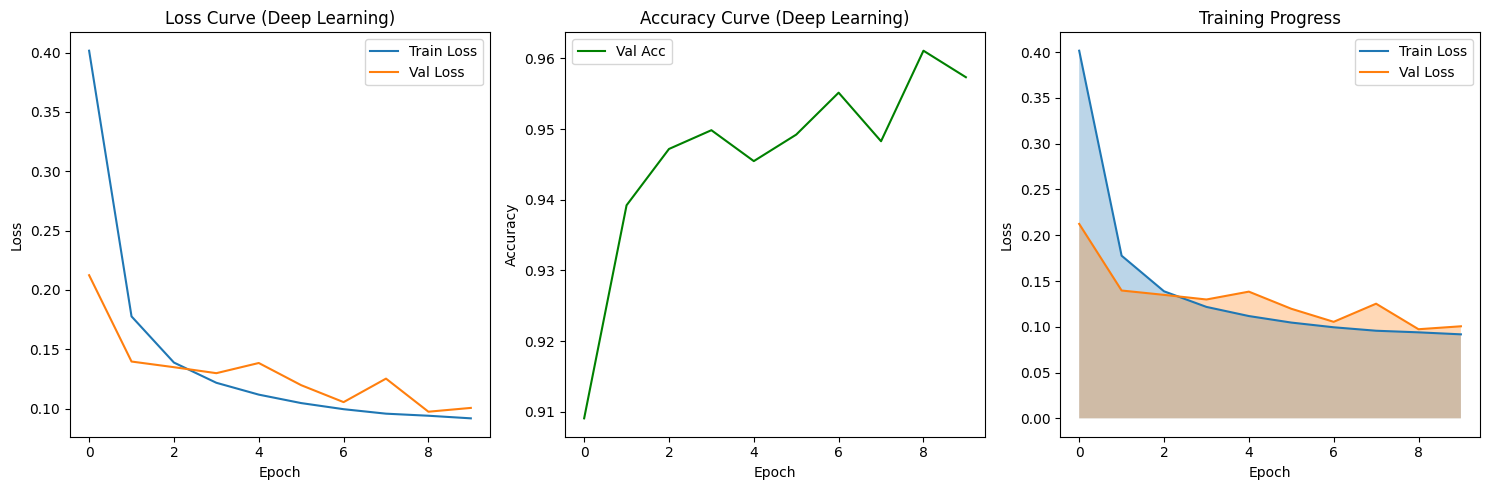

In [10]:
# 10. 训练曲线可视化
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve (Deep Learning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,3,2)
plt.plot(val_accuracies, label='Val Acc', color='green')
plt.legend()
plt.title("Accuracy Curve (Deep Learning)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1,3,3)
epochs_range = range(len(train_losses))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.fill_between(epochs_range, train_losses, alpha=0.3)
plt.fill_between(epochs_range, val_losses, alpha=0.3)
plt.legend()
plt.title("Training Progress")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

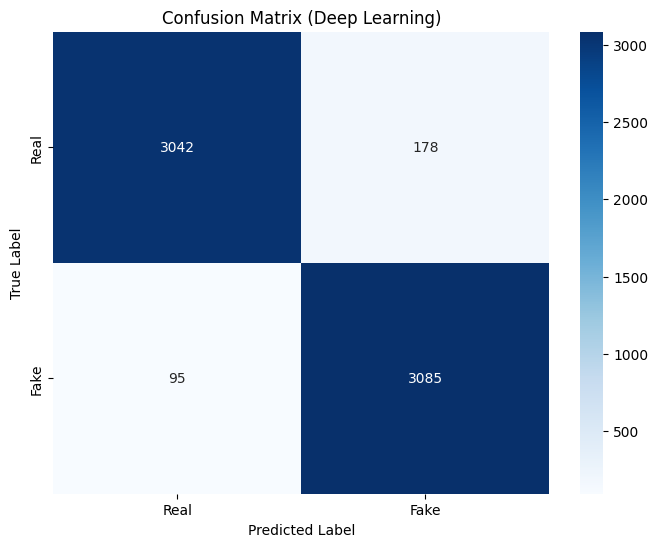


深度学习训练完成！
              precision    recall  f1-score   support

        Real       0.97      0.94      0.96      3220
        Fake       0.95      0.97      0.96      3180

    accuracy                           0.96      6400
   macro avg       0.96      0.96      0.96      6400
weighted avg       0.96      0.96      0.96      6400



In [11]:
# 11. 混淆矩阵 & 报告
plt.figure(figsize=(8,6))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Deep Learning)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print("\n" + "="*50)
print("深度学习训练完成！")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=classes))

In [12]:
# 12. 最终统计
print(f"\n📊 训练统计:")
print(f"总训练轮数: {len(train_losses)}")
print(f"最佳验证损失: {best_val_loss:.4f}")
print(f"最终验证准确率: {val_accuracies[-1]:.4f}")
print(f"最高验证准确率: {max(val_accuracies):.4f}")
print(f"模型保存路径: best_model_deep_learning.pth")


📊 训练统计:
总训练轮数: 10
最佳验证损失: 0.0973
最终验证准确率: 0.9573
最高验证准确率: 0.9611
模型保存路径: best_model_deep_learning.pth
